In [1]:
import numpy as np
import argparse
import time
import os
import sys
import pickle
from itertools import chain
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from datasets import inputs, sf_inputs_discrete
from sr_model.models.models import AnalyticSR, STDP_SR, Linear
import configs
from eval import eval
from copy import deepcopy

device = 'cpu'

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/Users/chingfang/Code/sr-project/datasets/sf_inputs_discrete.py:19: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [99]:
gamma = 0.8
num_steps = 3000
num_states = 25
left_right_stay_prob = [1, 6, 1]
stop_idx = 100
sprs = 0.02
sig = 2.
lr = 1E-2
    

# Get development over walk

In [105]:
def get_shifts(sprs, sig, onehot=False):
    # Set up net
    ca3_kwargs = {'lr':lr}
    net = AnalyticSR(num_states, gamma, ca3_kwargs=ca3_kwargs)
    
    # Set up dataset
    if onehot:
        dset = inputs.Sim1DWalk(
            num_steps=num_steps, left_right_stay_prob=left_right_stay_prob,
            num_states=num_states
            )
    else:
        feature_maker_kwargs = {                                     
            'feature_dim': num_states,
            'feature_type': 'correlated_distributed',
            'feature_vals_p': [1-sprs, sprs], 'feature_vals': None,
            'spatial_sigma': sig
            }
        dset = sf_inputs_discrete.Sim1DWalk(
            num_steps=num_steps, feature_maker_kwargs=feature_maker_kwargs,
            num_states=num_states, left_right_stay_prob=left_right_stay_prob
            )
    dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().unsqueeze(1)
    dg_modes = torch.from_numpy(dset.dg_modes.T).float().unsqueeze(1)

    # First few minutes of walk
    _, outputs = net(dg_inputs[:stop_idx], dg_modes[:stop_idx], reset=True)
    ff_M = []
    for neur in range(num_states):
        ff = []
        for state in range(num_states):
            ff.append(np.mean(
                outputs[dset.ys[:stop_idx]==state,neur].detach().numpy()
                ))
        ff_M.append(ff)
    ff_M = np.array(ff_M)
    init_argsort = np.argsort(np.argmax(ff_M,axis=1)).astype(int)
    init_peaks = np.argmax(ff_M[init_argsort,:], axis=0)

    # Run full walk
    _, outputs = net(dg_inputs, dg_modes, reset=True)
    ff_M = []
    for neur in range(num_states):
        ff = []
        for state in range(num_states):
            ff.append(np.mean(
                outputs[dset.ys==state,neur].detach().numpy()
                ))
        ff_M.append(ff)
    ff_M = np.array(ff_M)
    peaks = np.argmax(ff_M[init_argsort,:], axis=0)

    # Get shifts
    _shifts = peaks - init_peaks
    shifts = []
    for _shift in _shifts:
        equiv_vals = [_shift, _shift-num_states, _shift+num_states]
        equiv_val = equiv_vals[np.argmin(np.abs(equiv_vals))]
        shifts.append(equiv_val)
    shifts = np.array(shifts)

    return shifts

In [107]:
feature_shifts = []
for _ in range(40):
    _shifts = get_shifts(sprs, sig)
    feature_shifts.append(np.mean(_shifts))
feature_shifts = np.array(feature_shifts)

In [112]:
onehot_shifts = []
for _ in range(40):
    _shifts = get_shifts(sprs, sig, onehot=True)
    onehot_shifts.append(np.mean(_shifts))
onehot_shifts = np.array(onehot_shifts)

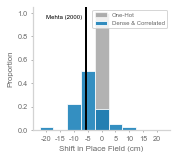

In [117]:
plt.figure(figsize=(2.5, 2.25))
bins = np.arange(-5, 5)
plt.hist(
    onehot_shifts*-1, bins=bins+0.5, label='One-Hot',
    weights=[1/onehot_shifts.size]*onehot_shifts.size,
    color='Gray', alpha=0.6
    )
plt.hist(
    feature_shifts*-1, bins=bins+0.5,
    label='Dense & Correlated',
    weights = [1/feature_shifts.size]*feature_shifts.size,
    color='C0', alpha=0.8
    )
plt.legend()
plt.ylabel('Proportion')
plt.xlabel('Shift in Place Field (cm)')
plt.xticks(bins[1:], bins[1:]*configs.bin_to_cm)
mehta_avg = 5.5/configs.bin_to_cm
mehta_std = 1./configs.bin_to_cm
plt.axvline(-mehta_avg, color='black', linewidth=2, linestyle='-')
ax = plt.gca()
ax.text(-4., 0.95, 'Mehta (2000)', fontsize=6, color='black')
plt.tight_layout()
plt.savefig('../figures/4d.png', dpi=300, transparent=True)
plt.show()